https://medium.com/mlearning-ai/time-series-forecasting-with-xgboost-and-lightgbm-predicting-energy-consumption-with-lag-features-dbf69970a90f

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from matplotlib.offsetbox import AnchoredText
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pathlib
import pickle
import os
import seaborn as sns
import math

In [ ]:
def evaluate_model(y_test, prediction):
    print(f"MAE:  {mean_absolute_error(y_test, prediction)}")
    print(f"MSE:  {mean_squared_error(y_test, prediction)}")
    print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

In [ ]:
def plot_predictions(testing_dates, y_test, prediction, title = 'title'):
    df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
    figure, ax = plt.subplots(figsize=(10, 5))
    df_test.plot(ax=ax, label="Actual", x="date", y="actual")
    df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
    plt.legend(["Actual", "Prediction"])
    plt.title(title)
    plt.show()

In [ ]:
def plot_lag(x, lag=1, ax=None, **kwargs):
    x_ = x.shift(lag)
    y_ = x
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line = dict(color='C3', )

    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    
    # Adding correlation on plot
    at = AnchoredText(
        f"{y_.corr(x_):.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

In [ ]:
def plot_autocorrelation(x, lags=6, lagplot_kwargs={}, **kwargs):
    kwargs.setdefault("nrows", 2)
    kwargs.setdefault("ncols", math.ceil(lags / 2))
    kwargs.setdefault("figsize", (kwargs["ncols"] * 2, 2  * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(2 * kwargs["ncols"])):
        if k + 1 <= lags:
            ax = plot_lag(x, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag #{k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis("off")
    plt.setp(axs[-1, :], xlabel=x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [ ]:
def create_lag_features(df, col_name = '', lags = 3):
    df = df.copy()
    y = df.loc[:, col_name]
    for lag in range(lags):
        df[f"{col_name}_lag_{lag + 1}"] = y.shift(lag + 1)
    return df

# Path data

In [ ]:
path_data = '../data/data combined (aqcin)/combined aqicn data (all german cities).csv'

In [ ]:
df_data_all_cities = pd.read_csv(path_data)

In [ ]:
df_data = df_data_all_cities.copy()

# Data preprocessing

In [ ]:
df_data['date'] = pd.to_datetime(df_data['date'])
df_data.sort_values(by='date', ascending=True, inplace=True)
df_data.rename(columns={' pm10':'pm10', ' pm25':'pm25'}, inplace=True)
df_data.replace(' ', np.nan, inplace=True) 
df_data['pm10'] = pd.to_numeric(df_data['pm10']) # , downcast='float'
df_data['pm25'] = pd.to_numeric(df_data['pm25']) # , downcast='float'
df_data.replace({'munich':'Munich','berlin,-germany':'Berlin',
                 'potsdam-zentrum,-germany':'Potsdam',
                 'hannover,-germany':'Hannover',
                 'stuttgart-bad-cannstatt, germany':'Stuttgart',
                 'dresden-bergstraße,-germany':'Dresden',
                 'sternschanze,-hamburg, germany':'Hamburg',
                 'frankfurt-schwanheim,-germany':'Frankfurt',
                 'kiel-bahnhofstr.-verk., schleswig-holstein, germany':'Kiel'}, inplace=True )

In [ ]:
# drop nan values
df_data.dropna(axis = 0, inplace = True)

In [ ]:
df_data.isnull().sum()

In [ ]:
df_data.columns

In [ ]:
# convert string columns into numeric 
df_data['pm25'] = pd.to_numeric(df_data['pm25'], errors='coerce')
df_data['pm10'] = pd.to_numeric(df_data['pm10'], errors='coerce')

In [ ]:
df_data.head()

In [ ]:
df_data.reset_index(drop = True, inplace = True)

In [ ]:
df_berlin = df_data[df_data['city'] == 'Berlin']

In [ ]:
df_berlin.reset_index(drop = True, inplace = True)

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(df_berlin['date'], df_berlin['pm25'])
plt.title('Berlin PM25')

# Feature Engineering (1)

Datetime Features

Extract different features based on the full date such as the day of the week, the day of the year, the month and others

In [ ]:
df_berlin['year'] = df_berlin['date'].dt.year
df_berlin['month'] = df_berlin['date'].dt.month
df_berlin['day'] = df_berlin['date'].dt.day
df_berlin['day_of_year'] = df_berlin['date'].dt.dayofyear
df_berlin['day_of_week'] = df_berlin['date'].dt.dayofweek
df_berlin['quarter'] = df_berlin['date'].dt.quarter

In [ ]:
df_berlin.head()

# Train Test Split

Contrary to the conventional train/test split in timeseries we can't just split the data randomly. Sequence of the data is important in timeseries.

In [ ]:
train_size = int(len(df_berlin) * 0.75)

train_data = df_berlin[0:train_size]
test_data = df_berlin[train_size:]

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))
train_data.plot(ax = ax, label = 'Training', x = 'date', y = 'pm25')
test_data.plot(ax = ax, label = 'Testing', x = 'date', y = 'pm25')
fig.show()

Drop the data column and create training and testing sets

In [ ]:
training_dates = train_data['date']
testing_dates = test_data['date']

# train test split
X_train = train_data[['year', 'month', 'day', 'day_of_year', 'day_of_week', 'quarter']]
y_train = train_data['pm25']

X_test = test_data[['year', 'month', 'day', 'day_of_year', 'day_of_week', 'quarter']]
y_test = test_data['pm25']

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

The grid search takes parameters and some values as configuration and tries out every possible combination. The parameter configuration that achieves the best result, will be the one to form the best estimator.

Due to the nature of the problem we can’t just use plain k-fold cross validation. Scikit learn provides the TimeSeriesSplit method which splits the data incrementally in a respectful manner in terms of continuity.

# Model Training

## XGBoost

In [ ]:
cv_split = TimeSeriesSplit(n_splits=4)

model = XGBRegressor()

parameters = {"max_depth": [3, 5, 7],
              "learning_rate": [0.01, 0.05, 0.1, 0.3],
              "n_estimators": [100, 300, 500, 700],
              "colsample_bytree": [0.3, 0.5, 0.7, 0.9]}

xg_boost_grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
xg_boost_grid_search.fit(X_train, y_train)

## LGBM

In [ ]:
cv_split = TimeSeriesSplit(n_splits=4)

model = lgb.LGBMRegressor()

parameters = {"max_depth": [3, 4, 6, 10],
              "num_leaves": [10, 30, 100, 500],
              "learning_rate": [0.01, 0.1, 0.3, 0.6],
              "n_estimators": [50, 300, 500, 800],
              "colsample_bytree": [0.3, 0.5, 0.7, 1]}


lgbm_grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
lgbm_grid_search.fit(X_train, y_train)

In [ ]:
# Evaluating GridSearch results
prediction_xg_boost = xg_boost_grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction_xg_boost, title = 'XGBoost')
evaluate_model(y_test, prediction_xg_boost)

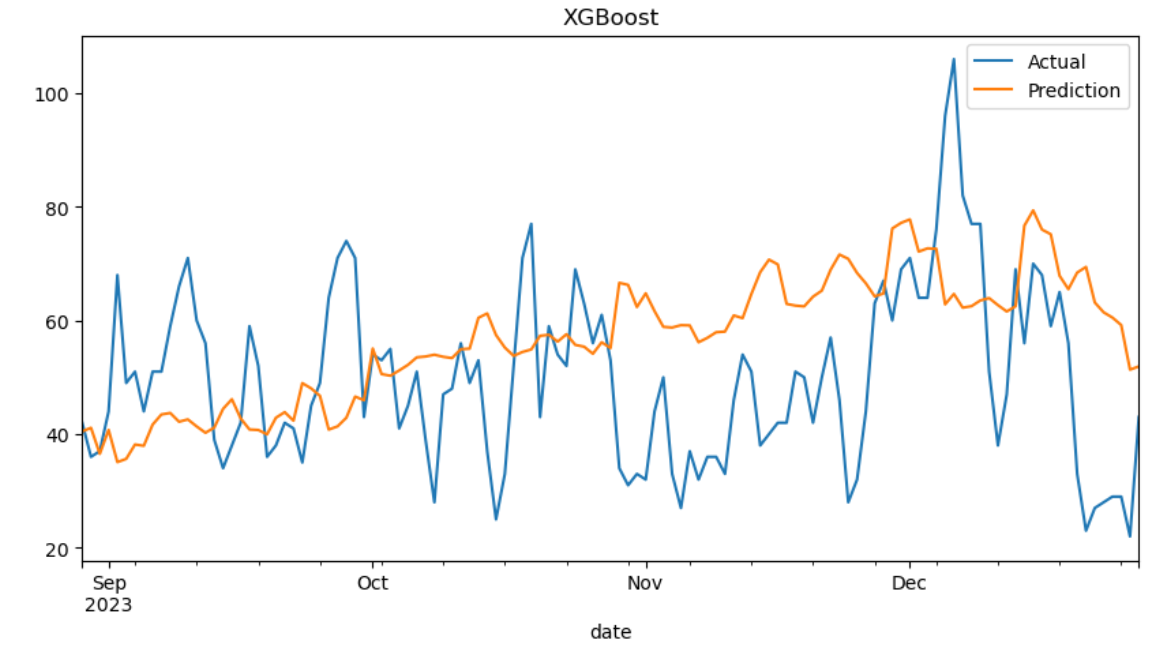

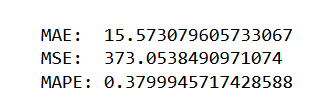

In [ ]:
# Evaluating GridSearch results
prediction_lgbm = lgbm_grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction_lgbm, title = 'LGBM')
evaluate_model(y_test, prediction_lgbm)

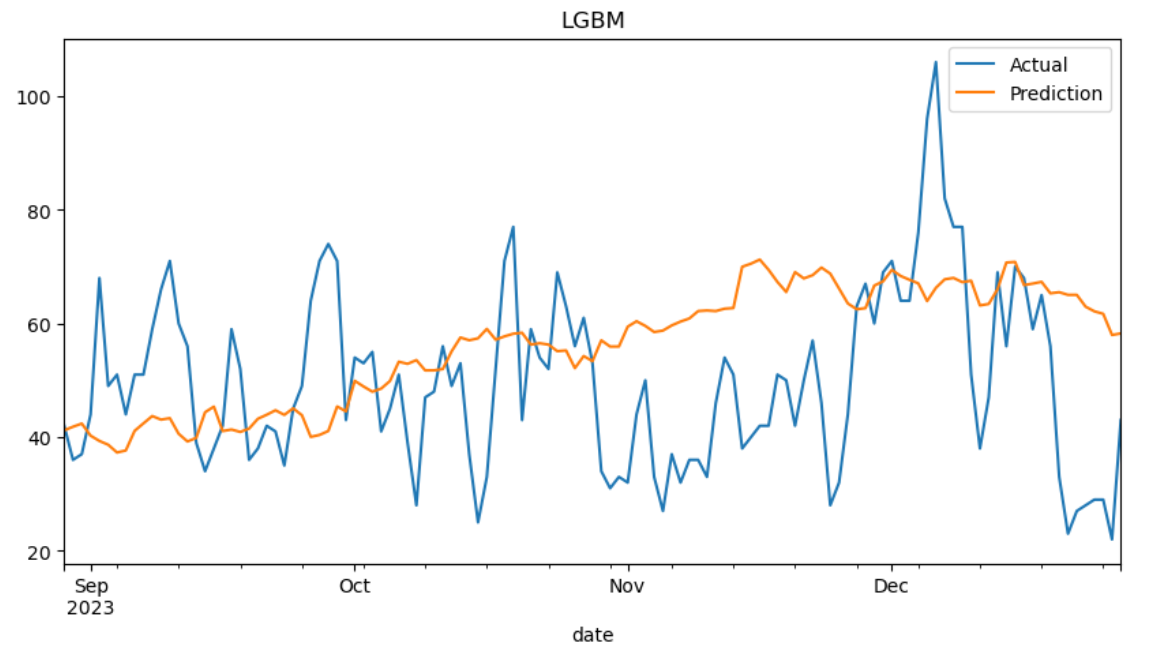

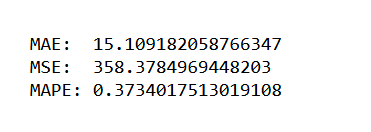

# Feature Engineering (2)

Lag Features

In [ ]:
_ = plot_autocorrelation(df_berlin["pm25"], lags=12)

In [ ]:
_ = plot_pacf(df_berlin["pm25"], lags=12)

Those which are out of the blue region are good for choosing

In [ ]:
df_berlin_lag_features = create_lag_features(df_berlin, col_name = 'pm25', lags = 3)

It should be noted that after adding the new lag features, the initial samples will contain NaN values. Generally speaking, the missing values should be filled-in somehow, but since we use XGBoost and LGBM we can leave them as is and our algorithms will take care of them.

The lag features will create NaN values for some rows. This can throw an error when we use this data for training of different machine learning algorithms. But in case of XGBoost and LGBM we don't need to worry about this. They will automatically take care of NaN values.

# Train Test Split

In [ ]:
df_berlin_lag_features

In [ ]:
train_size = int(len(df_berlin_lag_features) * 0.75)

train_data = df_berlin_lag_features[0:train_size]
test_data = df_berlin_lag_features[train_size:]

In [ ]:
training_dates = train_data['date']
testing_dates = test_data['date']

# train test split
X_train = train_data[['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3']]
y_train = train_data['pm25']

X_test = test_data[['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3']]
y_test = test_data['pm25']

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Model Training

## XGBoost

In [ ]:
cv_split = TimeSeriesSplit(n_splits=4)

model = XGBRegressor()

parameters = {"max_depth": [3, 5, 7],
              "learning_rate": [0.01, 0.05, 0.1, 0.3],
              "n_estimators": [100, 300, 500, 700],
              "colsample_bytree": [0.3, 0.5, 0.7, 0.9]}

xg_boost_grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
xg_boost_grid_search.fit(X_train, y_train)

## LGBM

In [ ]:
cv_split = TimeSeriesSplit(n_splits=4)

model = lgb.LGBMRegressor()

parameters = {"max_depth": [3, 4, 6, 10],
              "num_leaves": [10, 30, 100, 500],
              "learning_rate": [0.01, 0.1, 0.3, 0.6],
              "n_estimators": [50, 300, 500, 800],
              "colsample_bytree": [0.3, 0.5, 0.7, 1]}


lgbm_grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
lgbm_grid_search.fit(X_train, y_train)

In [ ]:
# Evaluating GridSearch results
prediction_xg_boost = xg_boost_grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction_xg_boost, title = 'XGBoost')
evaluate_model(y_test, prediction_xg_boost)

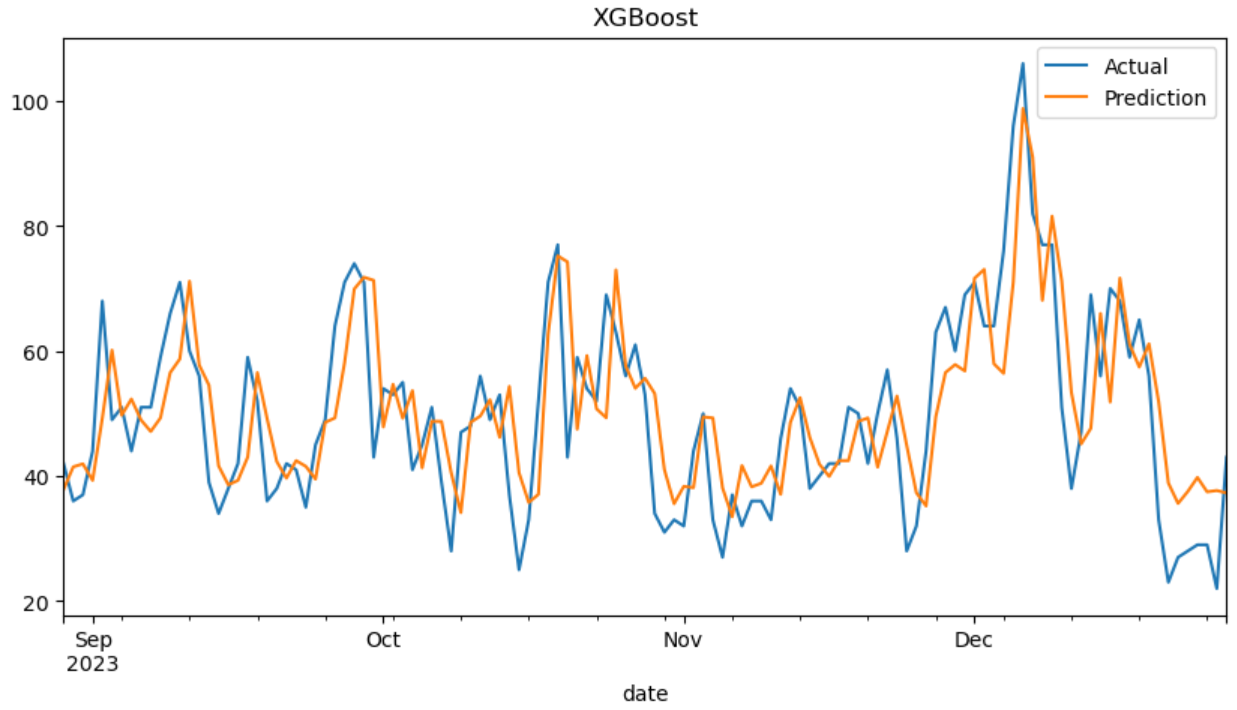

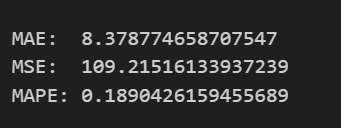

In [ ]:
# Evaluating GridSearch results
prediction_lgbm = lgbm_grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction_lgbm, title = 'LGBM')
evaluate_model(y_test, prediction_lgbm)

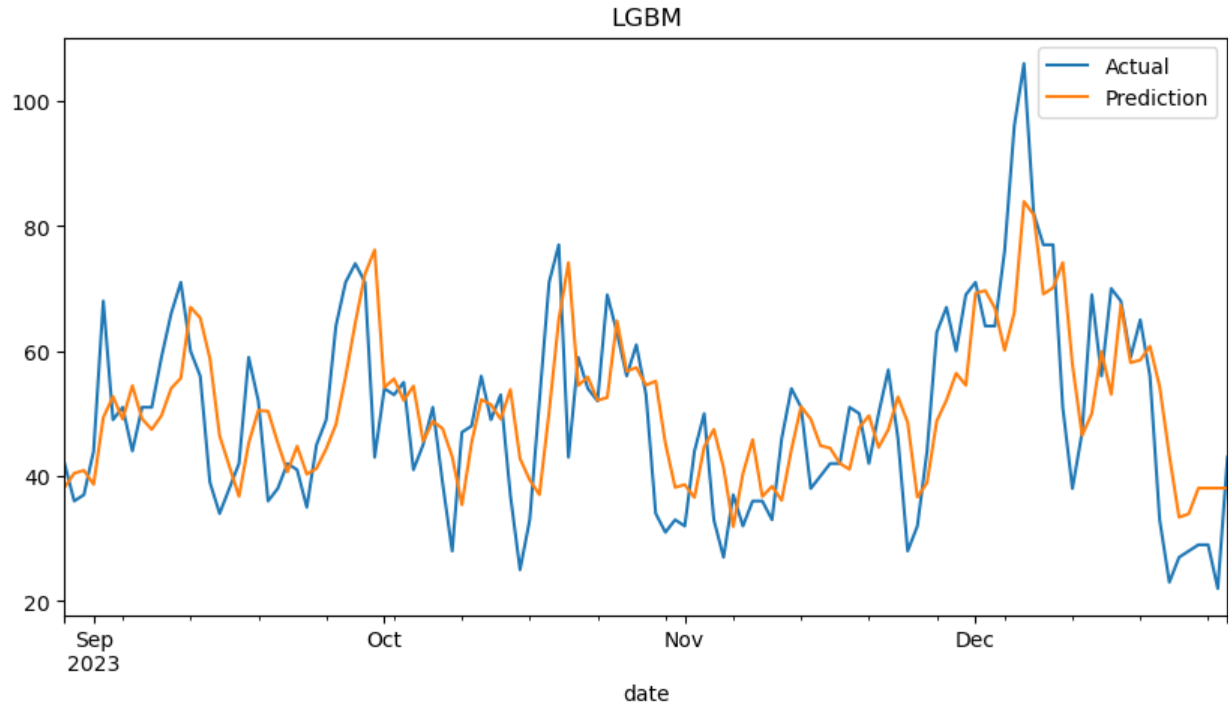

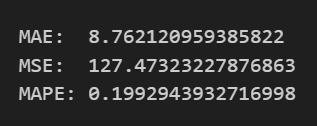